#**Libraries**

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
from tensorflow import keras
from sklearn.manifold import TSNE

In [42]:
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")

def show_reconstructions(model, n_images=15):
  reconstructions = model.predict(X_valid[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))

  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plot_image(X_valid[image_index])
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plot_image(reconstructions[image_index])

def rounded_accuracy(y_true, y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


In [3]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

X_train = X - X.mean(axis=0, keepdims=0)
X_train.shape

(60, 3)

#**PCA with an Under complete Linear Autoencoder**

$$\widehat{\textbf{X}}=\textbf{W}^{\top}\textbf{X}$$


In [4]:
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.1))

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 5s 16ms/step - loss: 0.8039
Epoch 2/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7691
Epoch 3/20
2/2 [==============================] - 0s 10ms/step - loss: 0.7370
Epoch 4/20
2/2 [==============================] - 0s 11ms/step - loss: 0.7068
Epoch 5/20
2/2 [==============================] - 0s 13ms/step - loss: 0.6793
Epoch 6/20
2/2 [==============================] - 0s 12ms/step - loss: 0.6540
Epoch 7/20
2/2 [==============================] - 0s 21ms/step - loss: 0.6303
Epoch 8/20
2/2 [==============================] - 0s 14ms/step - loss: 0.6083
Epoch 9/20
2/2 [==============================] - 0s 18ms/step - loss: 0.5879
Epoch 10/20
2/2 [==============================] - 0s 14ms/step - loss: 0.5696
Epoch 11/20
2/2 [==============================] - 0s 13ms/step - loss: 0.5516
Epoch 12/20
2/2 [==============================] - 0s 8ms/step - loss: 0.5352
Epoch 13/20
2/2 [==============================] - 0s 9ms/step

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 4ms/step


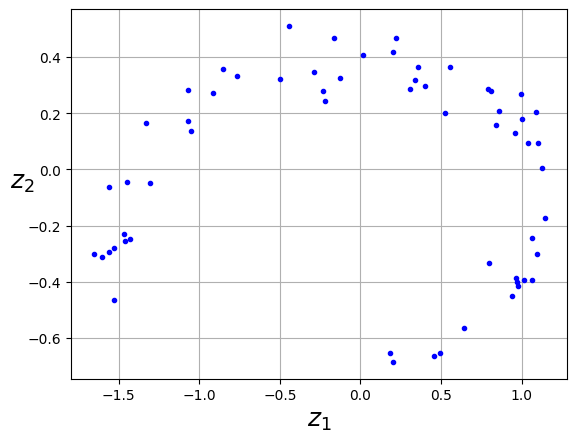

In [7]:
plt.figure()
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

#**Stacked Autoencoders**

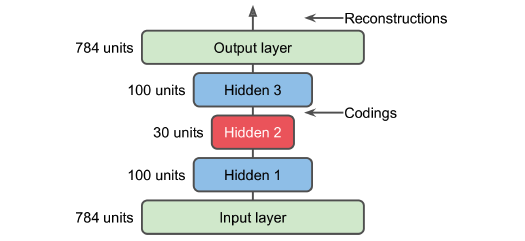

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


4422102/4422102 [==============================] - 0s 0us/step


In [9]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

In [10]:
stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                           keras.layers.Dense(100, activation="selu"),
                                           keras.layers.Dense(30, activation="selu"),])

stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation="selu", input_shape=[30]),
                                           keras.layers.Dense(28 * 28, activation="sigmoid"),
                                           keras.layers.Reshape([28, 28])])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.SGD(lr=1.5))

stacked_ae.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 30)                81530     
                                                                 
 sequential_4 (Sequential)   (None, 28, 28)            82284     
                                                                 
Total params: 163814 (639.90 KB)
Trainable params: 163814 (639.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
history = stacked_ae.fit(X_train, X_train, epochs=10, validation_data=[X_valid, X_valid])


Epoch 1/10
1719/1719 [==============================] - 17s 4ms/step - loss: 0.6634 - val_loss: 0.6068
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5461 - val_loss: 0.5109
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4988 - val_loss: 0.4943
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4861 - val_loss: 0.4819
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4709 - val_loss: 0.4635
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4491 - val_loss: 0.4394
Epoch 7/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4246 - val_loss: 0.4155
Epoch 8/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4033 - val_loss: 0.3975
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3893 - val_loss: 0.3870
Epoch 10/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3

1/1 [==============================] - 0s 63ms/step


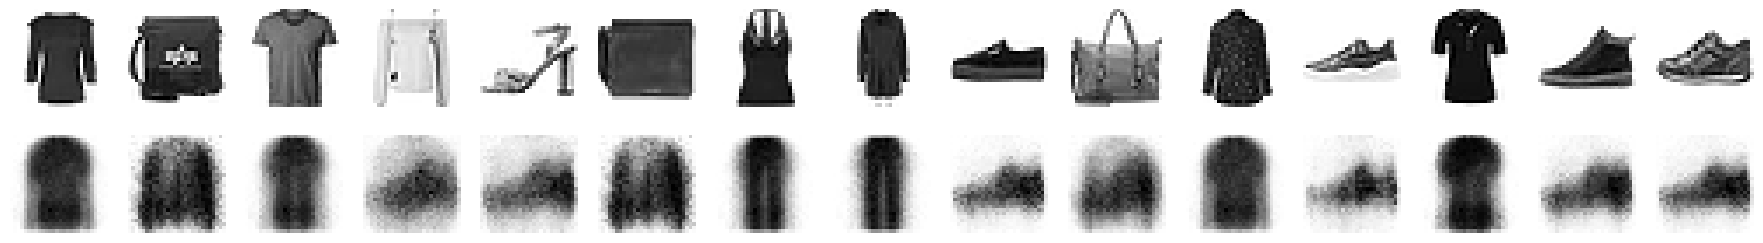

In [12]:
show_reconstructions(stacked_ae)

In [13]:
X_valid_compressed = stacked_encoder.predict(X_valid)

tsne = TSNE()

X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 1ms/step


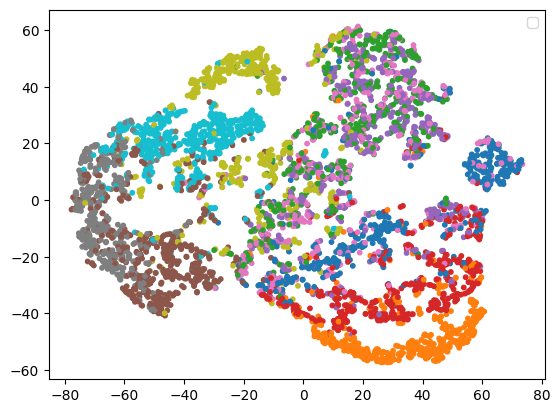

In [14]:
class_names = ["0","1","2","3","4","5","6","7","8","9"]

plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.legend()

#**Unsupervised Pretraining Using Stacked Autoencoders**

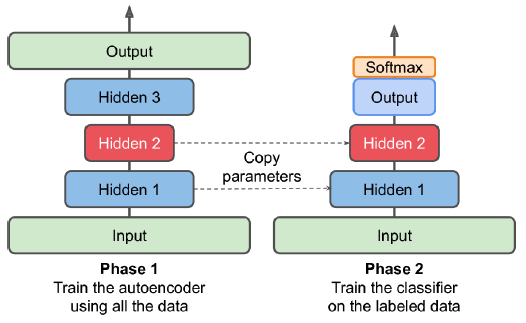

In [15]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self, dense, activation=None, **kwargs):
    self.dense = dense
    self.activation = keras.activations.get(activation)
    super().__init__(**kwargs)

  def build(self, batch_input_shape):
    self.biases = self.add_weight(name="bias", shape=[self.dense.input_shape[-1]], initializer="zeros")
    super().build(batch_input_shape)

  def call(self, inputs):
    z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
    return self.activation(z + self.biases)

In [16]:
dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]), dense_1, dense_2])

tied_decoder = keras.models.Sequential([DenseTranspose(dense_2, activation="selu"), DenseTranspose(dense_1, activation="sigmoid"), keras.layers.Reshape([28, 28]) ])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])
tied_ae.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 30)                81530     
                                                                 
 sequential_7 (Sequential)   (None, 28, 28)            82414     
                                                                 
Total params: 82414 (321.93 KB)
Trainable params: 82414 (321.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
tied_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])

history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6674 - rounded_accuracy: 0.5987 - val_loss: 0.6309 - val_rounded_accuracy: 0.6645
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5826 - rounded_accuracy: 0.7042 - val_loss: 0.5452 - val_rounded_accuracy: 0.7276
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5258 - rounded_accuracy: 0.7420 - val_loss: 0.5117 - val_rounded_accuracy: 0.7520
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4972 - rounded_accuracy: 0.7638 - val_loss: 0.4861 - val_rounded_accuracy: 0.7702
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4731 - rounded_accuracy: 0.7772 - val_loss: 0.4636 - val_rounded_accuracy: 0.7802
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4512 - rounded_accuracy: 0.7865 - val_loss: 0.4426 - val_rounded_accuracy: 0.7896
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 60ms/step


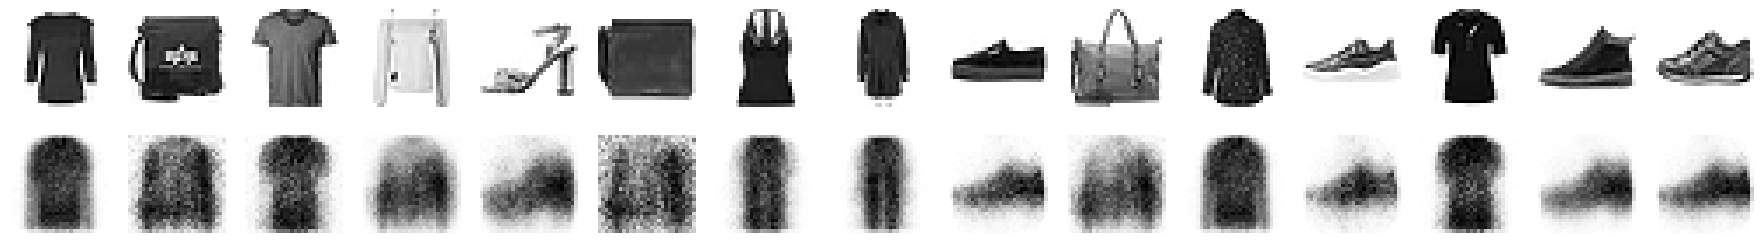

In [18]:
show_reconstructions(tied_ae)
plt.show()

#**Training One Autoencoder at a Time**

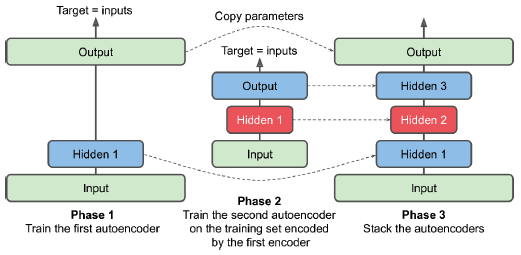

#**Convolutional Autoencoders**

In [19]:
conv_encoder = keras.models.Sequential([keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
                                        keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="selu"),
                                        keras.layers.MaxPool2D(pool_size=2),
                                        keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu"),
                                        keras.layers.MaxPool2D(pool_size=2),
                                        keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
                                        keras.layers.MaxPool2D(pool_size=2)])

conv_decoder = keras.models.Sequential([keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="selu", input_shape=[3, 3, 64]),
                                        keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="selu"),
                                        keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"), keras.layers.Reshape([28, 28])])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

conv_ae.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 3, 3, 64)          23296     
                                                                 
 sequential_10 (Sequential)  (None, 28, 28)            23233     
                                                                 
Total params: 46529 (181.75 KB)
Trainable params: 46529 (181.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 14s 6ms/step - loss: 0.3011 - rounded_accuracy: 0.9197 - val_loss: 0.2849 - val_rounded_accuracy: 0.9372
Epoch 2/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2762 - rounded_accuracy: 0.9412 - val_loss: 0.2766 - val_rounded_accuracy: 0.9434
Epoch 3/5
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2714 - rounded_accuracy: 0.9460 - val_loss: 0.2707 - val_rounded_accuracy: 0.9483
Epoch 4/5
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2686 - rounded_accuracy: 0.9491 - val_loss: 0.2696 - val_rounded_accuracy: 0.9476
Epoch 5/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.2667 - rounded_accuracy: 0.9511 - val_loss: 0.2692 - val_rounded_accuracy: 0.9484


1/1 [==============================] - 0s 307ms/step


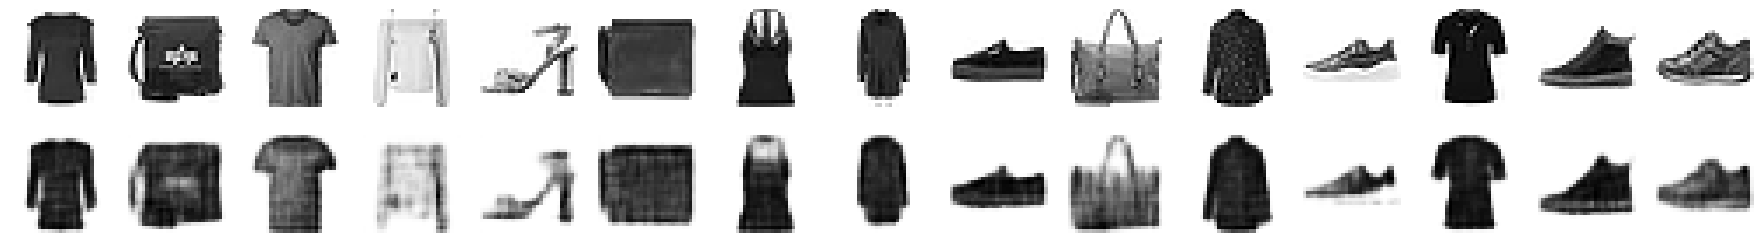

In [21]:
show_reconstructions(conv_ae)
plt.show()

#**Recurrent Autoencoders**

In [22]:
recurrent_encoder = keras.models.Sequential([keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
                                             keras.layers.LSTM(30)])

recurrent_decoder = keras.models.Sequential([keras.layers.RepeatVector(28, input_shape=[30]),
                                             keras.layers.LSTM(100, return_sequences=True),
                                             keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))])

recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])

recurrent_ae.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 30)                67320     
                                                                 
 sequential_13 (Sequential)  (None, 28, 28)            55228     
                                                                 
Total params: 122548 (478.70 KB)
Trainable params: 122548 (478.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 24s 11ms/step - loss: 0.3827 - rounded_accuracy: 0.8528 - val_loss: 0.3363 - val_rounded_accuracy: 0.8948
Epoch 2/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3254 - rounded_accuracy: 0.8968 - val_loss: 0.3218 - val_rounded_accuracy: 0.9037
Epoch 3/10
1719/1719 [==============================] - 19s 11ms/step - loss: 0.3143 - rounded_accuracy: 0.9055 - val_loss: 0.3165 - val_rounded_accuracy: 0.9034
Epoch 4/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3079 - rounded_accuracy: 0.9107 - val_loss: 0.3090 - val_rounded_accuracy: 0.9116
Epoch 5/10
1719/1719 [==============================] - 18s 10ms/step - loss: 0.3035 - rounded_accuracy: 0.9145 - val_loss: 0.3046 - val_rounded_accuracy: 0.9119
Epoch 6/10
1719/1719 [==============================] - 17s 10ms/step - loss: 0.3000 - rounded_accuracy: 0.9177 - val_loss: 0.2973 - val_rounded_accuracy: 0.9221
Epoch 7/10
1719/1719 [======

1/1 [==============================] - 1s 896ms/step


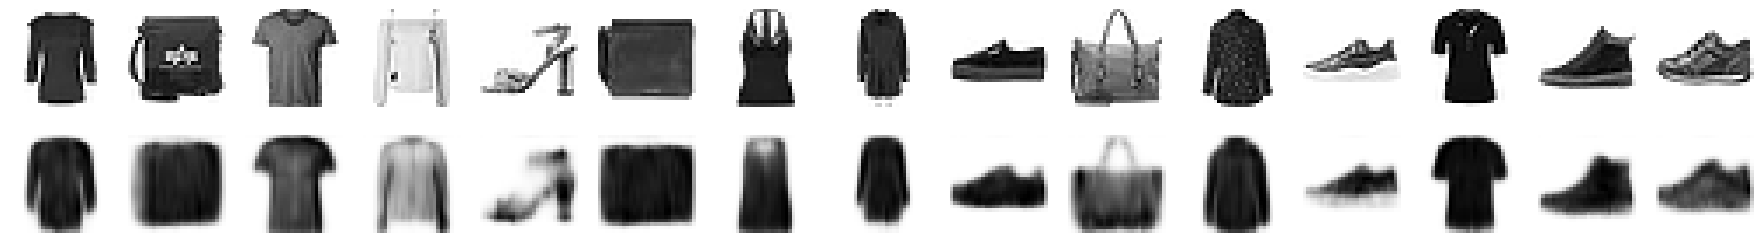

In [24]:
show_reconstructions(recurrent_ae)
plt.show()

#**Denoising Autoencoders**

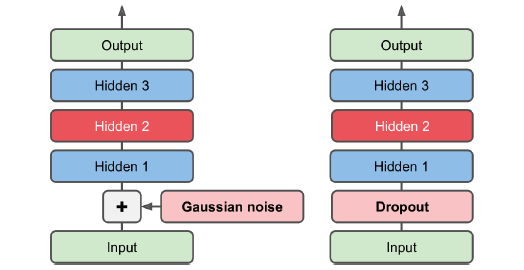

In [25]:
dropout_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                           keras.layers.Dropout(0.5),
                                           keras.layers.Dense(100, activation="selu"),
                                           keras.layers.Dense(30, activation="selu") ])

dropout_decoder = keras.models.Sequential([keras.layers.Dense(100, activation="selu", input_shape=[30]),
                                           keras.layers.Dense(28 * 28, activation="sigmoid"),
                                           keras.layers.Reshape([28, 28]) ])

dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_ae.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_15 (Sequential)  (None, 30)                81530     
                                                                 
 sequential_16 (Sequential)  (None, 28, 28)            82284     
                                                                 
Total params: 163814 (639.90 KB)
Trainable params: 163814 (639.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

history = dropout_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3537 - rounded_accuracy: 0.8725 - val_loss: 0.3190 - val_rounded_accuracy: 0.9054
Epoch 2/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3175 - rounded_accuracy: 0.9038 - val_loss: 0.3107 - val_rounded_accuracy: 0.9104
Epoch 3/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3115 - rounded_accuracy: 0.9086 - val_loss: 0.3062 - val_rounded_accuracy: 0.9140
Epoch 4/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3079 - rounded_accuracy: 0.9117 - val_loss: 0.3034 - val_rounded_accuracy: 0.9195
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3052 - rounded_accuracy: 0.9139 - val_loss: 0.3000 - val_rounded_accuracy: 0.9205


1/1 [==============================] - 0s 66ms/step


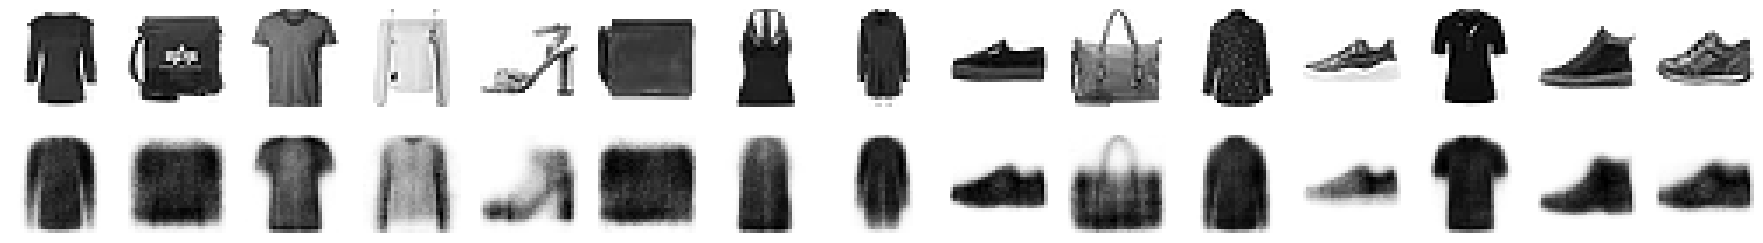

In [27]:
show_reconstructions(dropout_ae)
plt.show()

#**Sparse Autoencoders**

$$L_{activity} = \lambda ∑ |a|$$

In [28]:
sparse_l1_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(300, activation="sigmoid"),
                                             keras.layers.ActivityRegularization(l1=1e-3)] # Adds a training loss equal to the sum of absolute values of its inputs
                                            )

sparse_l1_decoder = keras.models.Sequential([keras.layers.Dense(100, activation="selu", input_shape=[300]),
                                             keras.layers.Dense(28 * 28, activation="sigmoid"),
                                             keras.layers.Reshape([28, 28])])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

sparse_l1_ae.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_18 (Sequential)  (None, 300)               108800    
                                                                 
 sequential_19 (Sequential)  (None, 28, 28)            109284    
                                                                 
Total params: 218084 (851.89 KB)
Trainable params: 218084 (851.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

history = sparse_l1_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4307 - rounded_accuracy: 0.8163 - val_loss: 0.3800 - val_rounded_accuracy: 0.8619
Epoch 2/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3686 - rounded_accuracy: 0.8699 - val_loss: 0.3633 - val_rounded_accuracy: 0.8714
Epoch 3/5
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3538 - rounded_accuracy: 0.8806 - val_loss: 0.3503 - val_rounded_accuracy: 0.8838
Epoch 4/5
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3441 - rounded_accuracy: 0.8876 - val_loss: 0.3431 - val_rounded_accuracy: 0.8883
Epoch 5/5
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3377 - rounded_accuracy: 0.8919 - val_loss: 0.3388 - val_rounded_accuracy: 0.8880


1/1 [==============================] - 0s 109ms/step


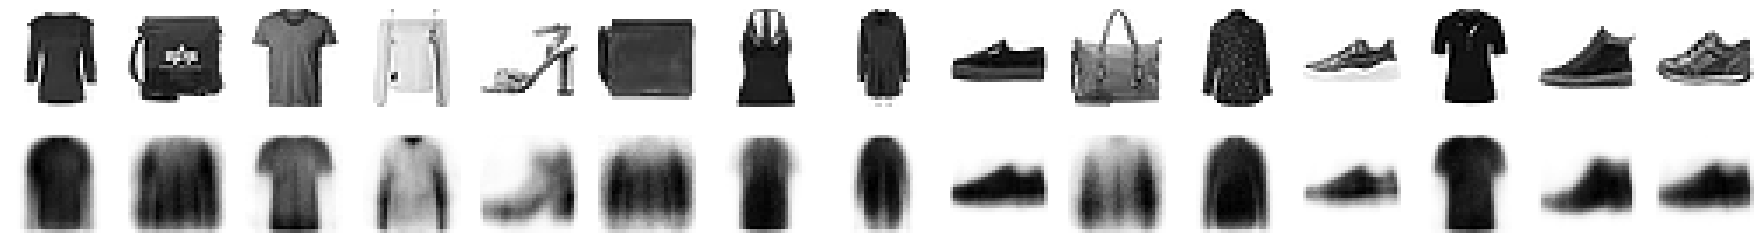

In [30]:
show_reconstructions(sparse_l1_ae)
plt.show()

Kullback lLeibler divergence

Quantifies the difference between two propbabilities distributions


$$ KL(P|Q) = - \sum_{i} p(i) \log \left( \frac{p(i)}{q(i)} \right) $$

$$ KL(P|Q) = p \log \left( \frac{p}{q} \right) + (1-p) \log \left( \frac{1-p}{1-q} \right) $$

In [31]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)

kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))

mse = (p - q)**2
mae = np.abs(p - q)

(0.0, 1.0, 0.0, 0.95)

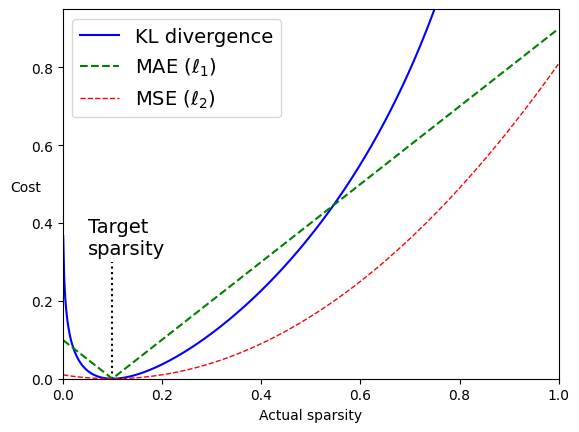

In [32]:
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")

plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [33]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
  def __init__(self, weight, target=0.1):
    self.weight = weight
    self.target = target

  def __call__(self, inputs):
    mean_activities = K.mean(inputs, axis=0)
    return self.weight * ( kl_divergence(self.target, mean_activities) + kl_divergence(1. - self.target, 1. - mean_activities))

In [52]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)

sparse_kl_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28, 28]),
                                             keras.layers.Dense(100, activation="selu"),
                                             keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
                                             ])

sparse_kl_decoder = keras.models.Sequential([keras.layers.Dense(100, activation="selu", input_shape=[300]),
                                             keras.layers.Dense(28 * 28, activation="sigmoid"),
                                             keras.layers.Reshape([28, 28])
                                             ])


sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])

sparse_kl_ae.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_33 (Sequential)  (None, 300)               108800    
                                                                 
 sequential_34 (Sequential)  (None, 28, 28)            109284    
                                                                 
Total params: 218084 (851.89 KB)
Trainable params: 218084 (851.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0), metrics=[rounded_accuracy])

history = sparse_kl_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4136 - rounded_accuracy: 0.8138 - val_loss: 0.3699 - val_rounded_accuracy: 0.8630
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3516 - rounded_accuracy: 0.8785 - val_loss: 0.3419 - val_rounded_accuracy: 0.8865
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3314 - rounded_accuracy: 0.8946 - val_loss: 0.3266 - val_rounded_accuracy: 0.9010
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3206 - rounded_accuracy: 0.9037 - val_loss: 0.3199 - val_rounded_accuracy: 0.9053
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3157 - rounded_accuracy: 0.9076 - val_loss: 0.3159 - val_rounded_accuracy: 0.9091
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3123 - rounded_accuracy: 0.9104 - val_loss: 0.3130 - val_rounded_accuracy: 0.9114
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 99ms/step


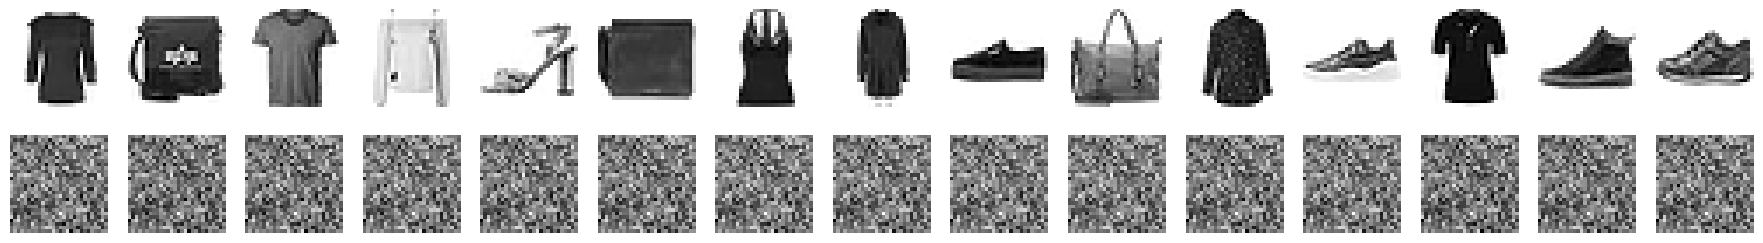

In [49]:
show_reconstructions(sparse_kl_ae)
plt.show()

In [50]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

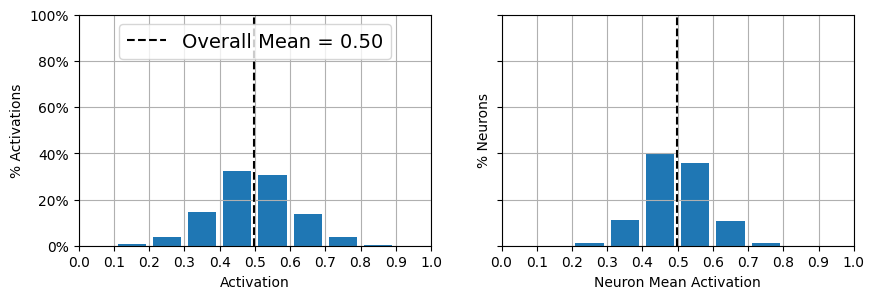

In [51]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()